# Kernel methods for biological sequence classification

MVA 2019 - Kernel methods for machine learning

*Éloïse Berthier, Guillaume Dalle, Clément Mantoux*

In [1]:
import os
import cProfile, pstats
import tqdm
import itertools

import numpy as np
import scipy.sparse as sp
import pandas as pd

import cvxpy as cp
import cvxopt
from qpsolvers import solve_qp
import osqp

import ray
ray.init()

import matplotlib.pyplot as plt

from vector_kernels import *

/home/clement/anaconda3/envs/mfds2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/clement/anaconda3/envs/mfds2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-02-13_11-10-25_17832/logs.
Waiting for redis server at 127.0.0.1:12764 to respond...
Waiting for redis server at 127.0.0.1:13403 to respond...
Starting Redis shard with 10.0 GB max memory.
Starting the Plasma object store with 3.2966148090000003 GB memory using /dev/shm.

View the web UI at http://localhost:8889/notebooks/ray_ui.ipynb?token=e3990e50e5e2d41127228e35d65361e1300b0fbac945c5b4



Reading data

In [3]:
def read_data_mat100(dataset="tr0"):
    folder = "kernel-methods-for-machine-learning-2018-2019"
    features_file = "X" + dataset + "_mat100.csv"
    labels_file = "Y" + dataset + ".csv"
    
    X = pd.read_csv(
        os.path.join(folder, features_file),
        sep=" ",
        header=None
    )
    if "te" in dataset:
        return np.array(X)
    
    elif "tr" in dataset:
        Y = pd.read_csv(
            os.path.join(folder, labels_file),
            sep=",",
            index_col=0,
        )
        return np.array(X), 2 * np.array(Y.iloc[:, 0]) - 1

In [4]:
def read_data_spectr(dataset="tr0", length = 3):
    folder = "kernel-methods-for-machine-learning-2018-2019/"
    features_file = "X" + dataset + '_spectr'+str(length)+'.csv'
    labels_file = "Y" + dataset + ".csv"
    
    X = pd.read_csv(
        os.path.join(folder, features_file),
        sep=" ",
        header=None
    )
    if "te" in dataset:
        return np.array(X)
    
    elif "tr" in dataset:
        Y = pd.read_csv(
            os.path.join(folder, labels_file),
            sep=",",
            index_col=0,
        )
        return np.array(X), 2 * np.array(Y.iloc[:, 0]) - 1

In [5]:
dataset = []
for k in [0, 1, 2]:
    #Xtr, Ytr = read_data_mat100("tr" + str(k))
    #Xte = read_data_mat100("te" + str(k))
    Xtr, Ytr = read_data_spectr("tr" + str(k), length=4)
    Xte = read_data_spectr("te" + str(k), length=4)
    dataset.append([Xtr, Ytr, Xte])

## SVM backend & Cross-Validation

Quadratic Program optimization for kernel SVM with ridge penalty

In [6]:
def compute_predictor(Xtr, Ytr, kernel, lambd, method="qpsolvers"):
    m = Xtr.mean(axis=0)
    s = Xtr.std(axis=0)
    Xc = (Xtr - m)/s

    n = len(Xc)

    I = np.eye(n)
    gram_matrix = kernel(Xc, Xc)
    K = gram_matrix + 1e-9*I
    
    if method == "cvxpy":
    
        alpha = cp.Variable(n)

        constraints = [
            cp.multiply(Ytr, alpha) >= np.zeros(n),
            cp.multiply(Ytr, alpha) <= np.ones(n) / (2 * lambd * n)
        ]

        objective = cp.Minimize(
            - 2 * (Ytr * alpha)
            + cp.quad_form(alpha, K)
        )

        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver=cp.OSQP, verbose=False)
        alpha_opt = alpha.value
        
    elif method == "qpsolvers":
        
        P = K
        q = - Ytr.astype(float)
        # Sparse G
        G = sp.vstack([
            -sp.diags(Ytr),
            sp.diags(Ytr)
        ]).tocsc().astype(float)
        h = np.hstack([
            np.zeros(n),
            np.ones(n) / (2 * lambd * n)
        ]).astype(float)
    
        alpha_opt = solve_qp(P=P, q=q, G=G, h=h, solver="cvxopt")
    
    return lambda x_new: np.sign(alpha_opt.dot(kernel(Xc, (x_new - m)/s)))

Profiling both optimization methods

In [7]:
Xtr, Ytr, _ = dataset[0]

#cProfile.run("f = compute_predictor(Xtr, Ytr, gauss(3), 1, method='cvxpy')", "profiling/stats1")
#pstats.Stats("profiling/stats1").strip_dirs().sort_stats("tottime").print_stats(20)

cProfile.run("f = compute_predictor(Xtr, Ytr, gauss(3), 1, method='qpsolvers')", "profiling/stats2")
pstats.Stats("profiling/stats2").strip_dirs().sort_stats("tottime").print_stats(20)

Wed Feb 13 11:12:55 2019    profiling/stats2

         2848 function calls (2828 primitive calls) in 1.368 seconds

   Ordered by: internal time
   List reduced from 277 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       16    0.689    0.043    0.689    0.043 {built-in method cvxopt.lapack.potrf}
        1    0.175    0.175    0.175    0.175 {method 'dot' of 'numpy.ndarray' objects}
        1    0.155    0.155    0.334    0.334 vector_kernels.py:9(kernel)
        8    0.109    0.014    0.824    0.103 misc.py:1389(factor)
       30    0.057    0.002    0.057    0.002 {built-in method cvxopt.blas.trsv}
        4    0.044    0.011    0.045    0.011 cvxopt_.py:29(cvxopt_matrix)
        1    0.030    0.030    1.363    1.363 <ipython-input-6-cdfb343cdacc>:1(compute_predictor)
        8    0.025    0.003    0.025    0.003 {built-in method cvxopt.base.syrk}
        1    0.014    0.014    0.014    0.014 {method 'read' of '_io.FileIO' ob

K-fold cross-validation

In [8]:
kfold = 5

def cross_validate(X, Y, kernel, lambd, shuffle=True, kfold=kfold):
    acc_train, acc_val = np.zeros(kfold), np.zeros(kfold)
    
    # jointly shuffle input datasets X, Y
    n = X.shape[0]
    if shuffle:
        perm = np.random.permutation(n)
        X, Y = X[perm], Y[perm]
    idx = np.arange(n)
    for k in range(kfold):
        # split the datasets
        val_idx = idx[k::kfold]
        train_idx = np.delete(idx, val_idx)
        n_train = len(train_idx)
        n_val = n - n_train
        
        X_train = X[train_idx]
        Y_train = Y[train_idx]
        X_val = X[val_idx]
        Y_val = Y[val_idx]
        
        # fit the predictor
        f = compute_predictor(X_train, Y_train, kernel, lambd)

        Yte_train = f(X_train).reshape(-1)
        Ypred_train = ((Yte_train + 1) / 2).astype(int)

        Yte_val = f(X_val).reshape(-1)
        Ypred_val = ((Yte_val + 1) / 2).astype(int)
        
        Y_train = ((Y_train + 1) / 2).astype(int)
        Y_val = ((Y_val + 1) / 2).astype(int)
        
        # compute metrics
        acc_train[k] = np.mean(Y_train == Ypred_train)
        acc_val[k] = np.mean(Y_val == Ypred_val)
    return acc_train, acc_val

Tool for pretty plots with mean + std

In [9]:
def lineplotCI(x, y, low, up, c, log=False):
    if log:
        plt.xscale("log")
    plt.plot(x, y, lw = 2, color = c, alpha = 1)
    plt.fill_between(x, low, up, color = c, alpha = 0.2)

## 2. Parameter tuning

### 2.1. Grid search on lambda for the linear kernel

In [12]:
lambd_range = np.logspace(-1.5, 3, 100)

acc_train = np.zeros((3, len(lambd_range), kfold))
acc_val = np.zeros((3, len(lambd_range), kfold))

for d, data in enumerate(dataset):
    Xtr, Ytr, _ = data
    for i in tqdm.trange(len(lambd_range), desc="Testing lambda for dataset {}".format(d+1)):
        lambd = lambd_range[i]
        acc_train[d, i], acc_val[d, i] = cross_validate(
            Xtr, Ytr,
            linear(), lambd,
            shuffle=True, kfold=kfold
        )

Testing lambda for dataset 3: 100%|██████████| 100/100 [06:13<00:00,  3.54s/it]


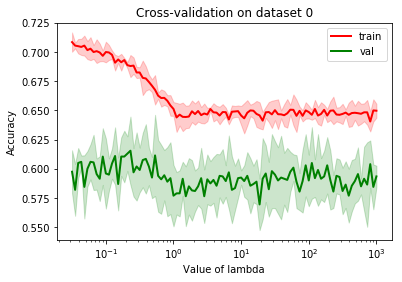

In [13]:
d = 0
plt.figure()
lineplotCI(
    lambd_range,
    acc_train[d].mean(axis=1),
    acc_train[d].mean(axis=1) + acc_train[d].std(axis=1),
    acc_train[d].mean(axis=1) - acc_train[d].std(axis=1),
    c='r',
    log=True
)
lineplotCI(
    lambd_range,
    acc_val[d].mean(axis=1),
    acc_val[d].mean(axis=1) + acc_val[d].std(axis=1),
    acc_val[d].mean(axis=1) - acc_val[d].std(axis=1),
    c='g',
    log=True
)
plt.legend(['train', 'val'])
plt.xlabel('Value of lambda')
plt.ylabel('Accuracy')
plt.title('Cross-validation on dataset {}'.format(d))
plt.show()

In [14]:
best_lambd = [
    lambd_range[np.argmax(np.mean(acc_val[d], axis=1))]
    for d in range(3)
]
print(best_lambd)

[0.23101297000831597, 0.16876124757881478, 0.38986037025490716]


### 2.2 Grid search on lambda & sigma for the gaussian kernel

In [10]:
lambd_range = np.logspace(-1.5, 1, 30)
sigma_range = np.linspace(3, 10, 30)
tuple_range = list(itertools.product(lambd_range, sigma_range))

acc_train = np.zeros((3, len(tuple_range), kfold))
acc_val = np.zeros((3, len(tuple_range), kfold))

In [15]:
@ray.remote
def joint_crossval(d, data):
    Xtr, Ytr, _ = data
    for i in tqdm.trange(len(tuple_range), desc="Testing (lambd, sigma) for dataset {}".format(d+1)):
        lambd, sigma = tuple_range[i]
        acc_train[d, i], acc_val[d, i] = cross_validate(
            Xtr, Ytr,
            gauss(sigma), lambd,
            shuffle=True, kfold=kfold
        )
    print("Finished dataset {}".format(d))

In [ ]:
tasks = []
for d, data in enumerate(dataset):
    tasks.append(joint_crossval.remote(d, data))
for t in tasks:
    ray.get(t)

In [52]:
best_tuple = [
    tuple_range[np.argmax(np.mean(acc_val[d], axis=1))]
    for d in range(3)
]
best_lambd = [bt[0] for bt in best_tuple]
best_sigma = [bt[1] for bt in best_tuple]

In [54]:
print(np.mean(acc_train[0], axis=1))
print(np.mean(acc_train[1], axis=1))
print(np.mean(acc_train[2], axis=1))
print(np.mean(acc_val[0], axis=1))
print(np.mean(acc_val[1], axis=1))
print(np.mean(acc_val[2], axis=1))
print(tuple_range)

[1.       0.981    0.848125 0.63925  0.56     1.       0.98025  0.839
 0.639625 0.55375  1.       0.9815   0.846375 0.62875  0.563125 1.
 0.981625 0.846375 0.634375 0.55275  1.       0.98075  0.851875 0.631375
 0.561875]
[1.       1.       0.899125 0.759125 0.6785   1.       1.       0.9185
 0.747    0.67575  1.       1.       0.920125 0.74325  0.677875 1.
 1.       0.915875 0.748875 0.6845   1.       1.       0.9195   0.749
 0.680375]
[1.       0.990125 0.685125 0.610625 0.58725  1.       0.990875 0.68575
 0.60975  0.58875  1.       0.990125 0.68625  0.611    0.5895   1.
 0.991875 0.685875 0.609625 0.586375 1.       0.991    0.688125 0.610375
 0.589   ]
[0.5635 0.569  0.5385 0.5245 0.5245 0.571  0.565  0.5385 0.5265 0.52
 0.5525 0.5745 0.5435 0.521  0.519  0.549  0.564  0.55   0.5355 0.516
 0.5615 0.5585 0.549  0.519  0.516 ]
[0.6525 0.655  0.6145 0.615  0.593  0.6605 0.6615 0.6525 0.6035 0.5935
 0.6575 0.6715 0.647  0.621  0.588  0.6565 0.663  0.6435 0.601  0.604
 0.65   0.668  0.641

Works quite well with **datasets 2 and 3 (not 1!)** and tends to overfit...

## 3. Final predictions

In [55]:
Ypred = []
lambd = 0.

for k in [0, 1, 2]:
    print("\nDATASET {}\n".format(k))

    Xtr, Ytr, Xte = dataset[k]
    
    f = compute_predictor(Xtr, Ytr, gauss(best_sigma[k]), best_lambd[k])
    #f = compute_predictor(Xtr, Ytr, linear(), best_lambd[k])
    print(np.mean(Ytr == f(Xtr)))
    Yte = f(Xte)
    
    Ypred.extend(list(((Yte + 1) / 2).astype(int)))
    
Ypred = pd.Series(
    index=np.arange(len(Ypred)),
    data=Ypred
)
Ypred.index.name = "Id"
Ypred.name = "Bound"
Ypred.to_csv("Ypred.csv", header=True)


DATASET 0

0.974

DATASET 1

1.0

DATASET 2

0.9845
